In [411]:
import numpy as np
from sklearn.model_selection import train_test_split
import csv
import random
import math
import statistics
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import confusion_matrix
import pylab as pl
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools

In [412]:
def loadCSV(filename):
    lines = csv.reader(open(filename))
    dataset = list(lines)
    for i in range(len(dataset)):
        dataset[i] = [float(x) for x in dataset[i]]
    return dataset

In [413]:
def makeBinary(dataset, labels):
    new = []
    for i in range(len(dataset)):
        vector = dataset[i]
        if any (vector[0] == label  for label in labels):
            new.append(vector)
    return new

In [414]:
def takePredefinedNoSamplesTrain(dataset, number, labels):
    new = []
    new1 = []
    copy = []
    for i in range(len(dataset)):
        vector = dataset[i]
        if vector[0] == labels[0]:
            copy.append(vector)
            
    while len(new) < number:
        index = random.randrange(len(copy))
        vector = copy[index]
        new.append(copy.pop(index))
        
    for i in range(len(dataset)):
        vector = dataset[i]
        if vector[0] == labels[1]:
            new1.append(vector)
            copy.append(vector)
    
    while len(new) < 2*number:
        index = random.randrange(len(new1))
        vector = new1[index]
        new.append(new1.pop(index))
        copy.remove(vector)
        
    return [new, copy] 

In [540]:
def prepareCrossValidationSets(dataset, ratio):
    data = {}
    i = 0
    trainSize = int(len(dataset))*ratio
    for i in range(10):
        trainset = []
        copy = list(dataset)
        while len(trainset) < trainSize:
            data[i] = []
            index = random.randrange(len(copy))
            trainset.append(copy.pop(index))
            data[i].append(trainset)
            data[i].append(copy)
        i= i+1
    return data

In [556]:
def calculatePrior(dataset, labels):
    label = labels[1]
    total = len(dataset)
    X = np.asarray(dataset)
    X = X[:,:1]
    X = X.flatten()
    X = X.tolist()
    prior = X.count(float(label))
    prior = prior/total
    return prior

In [557]:
def doStandardScaling(dataset):
    dataset = np.asarray(dataset)
    labels  = dataset[:,:1]
    features = dataset[:,1:]
    X_r = pd.DataFrame(StandardScaler().fit_transform(features))
    X=np.append(labels,X_r, axis = 1)
    data = X.tolist()
    return data

In [558]:
def separateByClass(dataset):
    separated = {}
    for i in range(len(dataset)):
        vector = dataset[i]
        if (vector[0] not in separated):
            separated[vector[0]] = []
        separated[vector[0]].append(vector)
    return separated

In [559]:
def varianceFeatures(dataset):
    var = []
    for attribute in zip(*dataset):
        var.append(statistics.variance(attribute))
    del var[0]
    return var

In [560]:
def meanFeatures(dataset):
    meanFeatures = [(statistics.mean(attribute)) for attribute in zip(*dataset)]
    del meanFeatures[0]
    return meanFeatures

In [561]:
def summarizeByClass(dataset):
    separated = separateByClass(dataset)
    meanFeaturesClass = {}
    for classValue, instances in separated.items():
        meanFeaturesClass[classValue] = meanFeatures(instances)  
    return meanFeaturesClass

In [562]:
def calculateWeights(mean, variance):
    weights = []
    for index in range (len(variance)):
        weights.append((mean[1][index] - mean[2][index])/(variance[index]))
    return weights

In [563]:
def calculateWeightZero(prior, mean, variance):
    weightZero = math.log((1-prior)/prior)
    for i in range(len(variance)):
        weightZero = weightZero + ((mean[1][i]*mean[1][i] - mean[2][i]*mean[2][i])/(2*variance[i]))
    return weightZero        

In [564]:
def calculatePosteriorProbabilities(weight0, weights, inputVector):
    labels = [1.0,2.0]
    prob = {}
    prob[labels[0]] = []
    prob[labels[1]] = []
    numerator = 0
    for i in range(len(weights)):
        numerator = numerator +  weights[i]*inputVector[i+1]
    num = math.exp(weight0 + numerator)
    prob[labels[0]].append((num/(1+num)))
    prob[labels[1]].append(1/(1+num))    
    return prob

In [565]:
def predict(weight0, weights, inputVector):
    probs = calculatePosteriorProbabilities(weight0, weights, inputVector)
    bestLabel, bestProb = None, -1
    for label, p in probs.items():
        if bestLabel is None or p > bestProb:
            bestProb = p
            bestLabel = label
    return bestLabel

In [566]:
def getPredictions(weight0, weights, testSet):
    predictions = []
    for i in range(len(testSet)):
        result = predict(weight0, weights, testSet[i])
        predictions.append(result)
    return predictions

In [567]:
def getAccuracy(testSet, predictions):
    correct = 0
    for i in range(len(testSet)):
        if testSet[i][0] == predictions[i]:
            correct += 1
    return (correct/float(len(testSet))) * 100.0

In [568]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
 


Using Wine dataset
With 5 samples for each class
130 10 120
Accuracy score:
95.83333333333334
Confusion matrix
[[54  0]
 [ 5 61]]


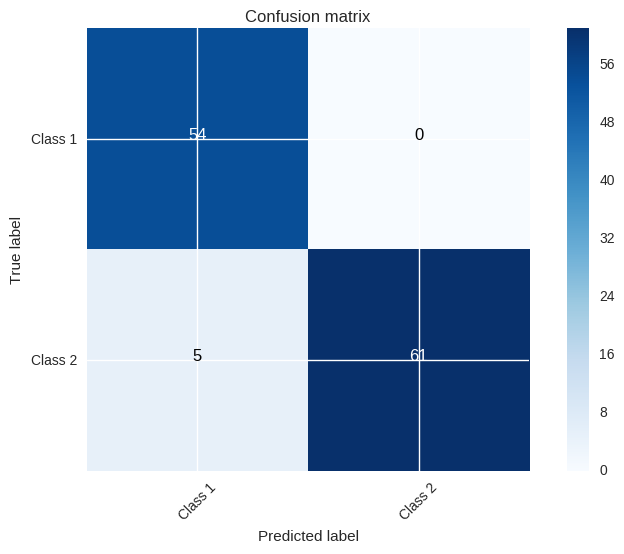

Split rows into train and test rows
130 100 30
Accuracy Score:
96.66666666666667
Confusion matrix
[[ 9  0]
 [ 1 20]]


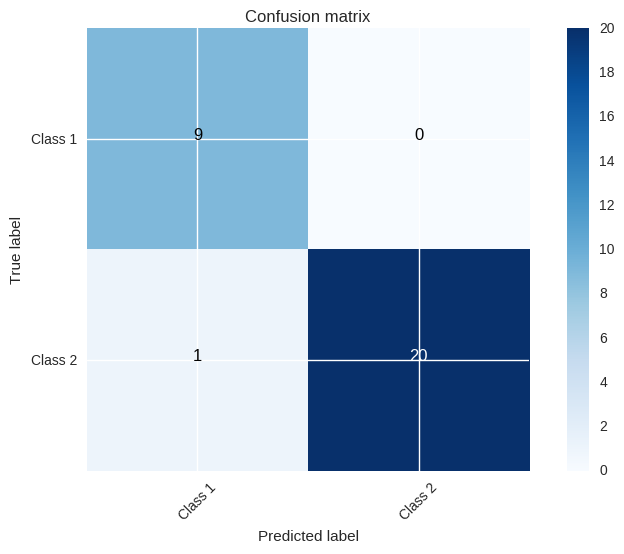

10 - fold cross Validation
K- Validation Accuracy- Scores
[100.0, 92.3076923076923, 100.0, 100.0, 84.61538461538461, 92.3076923076923, 100.0, 100.0, 100.0, 92.3076923076923]
Average
96.15384615384615


In [575]:
def main():
    print('Using Wine dataset')
    filename = 'wine.data.txt'
    dataset = loadCSV(filename)
    #select first two classes
    labels = [1,2]
    dataset = makeBinary(dataset, labels)
    #print(dataset)
    dataset = doStandardScaling(dataset)
    #print(dataset)
    trainingSet, testSet = takePredefinedNoSamplesTrain(dataset, 5, labels)
    print('With 5 samples for each class')
    print(len(dataset), len(trainingSet), len(testSet))
  
    # prepare model
    summaries = summarizeByClass(trainingSet)
    var = varianceFeatures(dataset)
    prior = calculatePrior(trainingSet, labels)
    weights = calculateWeights(summaries, var)
    weight0 = calculateWeightZero(prior, summaries, var)
    predictions = getPredictions(weight0, weights, testSet)
    accuracy1 = getAccuracy(testSet, predictions)
   
    print('Accuracy score:')
    print(accuracy1)
    
    Y = np.asarray(testSet)
    Y = Y[:,:1]
    Y_test = Y.tolist()
    accuracy = confusion_matrix(Y_test,predictions)
    classes = ['Class 1', 'Class 2']
    plt.figure()
    plot_confusion_matrix(accuracy, classes=classes,title='Confusion matrix')
    plt.show()
    
    
    
    

    
    trainingSet, testSet = takePredefinedNoSamplesTrain(dataset, 50, labels)
   
    print('Split rows into train and test rows')
    print(len(dataset), len(trainingSet), len(testSet))
    
    
    summaries = summarizeByClass(trainingSet)
    var = varianceFeatures(dataset)
    prior = calculatePrior(trainingSet, labels)
    weights = calculateWeights(summaries, var)
    weight0 = calculateWeightZero(prior, summaries, var)
    predictions = getPredictions(weight0, weights, testSet)
    accuracy2 = getAccuracy(testSet, predictions)
    
    
   
    
    
    print('Accuracy Score:')
    print(accuracy2)
    
    
    
    Y = np.asarray(testSet)
    Y = Y[:,:1]
    Y_test = Y.tolist()
    accuracy = confusion_matrix(Y_test,predictions)
    classes = ['Class 1', 'Class 2']
    plt.figure()
    plot_confusion_matrix(accuracy, classes=classes,title='Confusion matrix')
    plt.show()
    
    
    print('10 - fold cross Validation')
    data = prepareCrossValidationSets(dataset, 0.9)
    KAccuracy = []
    index = 0
    for i in range(10):
        trainingSet = data[index][0]
        testSet = data[index][1]   
        # prepare model
        summaries = summarizeByClass(trainingSet)
        var = varianceFeatures(dataset)
        prior = calculatePrior(trainingSet, labels)
        weights = calculateWeights(summaries, var)
        weight0 = calculateWeightZero(prior, summaries, var)
        predictions = getPredictions(weight0, weights, testSet)
        accuracy = getAccuracy(testSet, predictions)
        KAccuracy.append(accuracy)
        index = index + 1
    print('K- Validation Accuracy- Scores')
    print(KAccuracy)
    print('Average')
    print(sum(KAccuracy) / float(len(KAccuracy)))

main()